In [1]:
import gempyor
from gempyor import seir, config

## Show the different integration method side by side, but also act as a test of our integration

In [2]:
config_filepath = "../tests/npi/config_npi.yml"
gempyor_simulator = gempyor.InferenceSimulator(
    config_path=config_filepath,
    run_id="test_run_id",
    prefix="test_prefix/",
    first_sim_index=1,
    scenario="inference",  # NPIs scenario to use
    deathrate="med",  # Outcome scenario to use
    stoch_traj_flag=False,
    spatial_path_prefix="../tests/npi/",  # prefix where to find the folder indicated in spatial_setup$
)
config.clear()
config.read(user=False)
config.set_file(config_filepath)

  gempyor >> Running ***DETERMINISTIC*** simulation;
  gempyor >> Setup USA_inference; index: 1; run_id: test_run_id,
  gempyor >> prefix: test_prefix/;


In [3]:
# copied from InferenceSimulator/one_simulation

sim_id2write = 0
load_ID = False
sim_id2load = None

(
    gempyor_simulator.unique_strings,
    gempyor_simulator.transition_array,
    gempyor_simulator.proportion_array,
    gempyor_simulator.proportion_info,
) = gempyor_simulator.s.compartments.get_transition_array()
npi_seir = seir.build_npi_SEIR(s=gempyor_simulator.s, load_ID=load_ID, sim_id2load=sim_id2load, config=config)


initial_conditions = gempyor_simulator.s.seedingAndIC.draw_ic(sim_id2write, setup=gempyor_simulator.s)
seeding_data, seeding_amounts = gempyor_simulator.s.seedingAndIC.draw_seeding(sim_id2write, setup=gempyor_simulator.s)


p_draw = gempyor_simulator.s.parameters.parameters_quick_draw(
    n_days=gempyor_simulator.s.n_days, nnodes=gempyor_simulator.s.nnodes
)

parameters = gempyor_simulator.s.parameters.parameters_reduce(p_draw, npi_seir)

# Parse them
parsed_parameters = gempyor_simulator.s.compartments.parse_parameters(
    parameters, gempyor_simulator.s.parameters.pnames, gempyor_simulator.unique_strings
)
data = {}

INFO:root:[SEIR.compartments] completed in 26.78 s
INFO:root:[SEIR.NPI] completed in 26.93 s


In [4]:
data = {}

In [5]:
from importlib import reload

seir = reload(seir)

In [6]:
methods = ["legacy"]
dts = [1.0, 0.5]
for met in methods:
    for dt in dts:
        gempyor_simulator.s.integration_method = met
        gempyor_simulator.s.dt = float(dt)
        gempyor_simulator.s.stoch_traj_flag = False
        states = seir.steps_SEIR(
            gempyor_simulator.s,
            parsed_parameters,
            gempyor_simulator.transition_array,
            gempyor_simulator.proportion_array,
            gempyor_simulator.proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
        )
        data[f"{met}|dt={dt}|deter"] = seir.postprocess_and_write(
            sim_id2write, gempyor_simulator.s, states, p_draw, npi_seir, seeding_data
        )

INFO:root:Integrating with method legacy
977it [00:22, 42.64it/s]
INFO:root:Integrating with method legacy
1953it [00:43, 44.44it/s]


In [7]:
methods = ["rk4.jit"]
dts = [2.0, 1.0, 0.5]
for met in methods:
    for dt in dts:
        gempyor_simulator.s.integration_method = met
        gempyor_simulator.s.dt = float(dt)
        gempyor_simulator.s.stoch_traj_flag = False
        states = seir.steps_SEIR(
            gempyor_simulator.s,
            parsed_parameters,
            gempyor_simulator.transition_array,
            gempyor_simulator.proportion_array,
            gempyor_simulator.proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
        )
        data[f"{met}|dt={dt}|deter"] = seir.postprocess_and_write(
            sim_id2write, gempyor_simulator.s, states, p_draw, npi_seir, seeding_data
        )

INFO:root:Integrating with method rk4.jit
489it [00:44, 11.04it/s]
INFO:root:Integrating with method rk4.jit
977it [01:24, 11.52it/s]
INFO:root:Integrating with method rk4.jit
1953it [02:44, 11.88it/s]


In [8]:
methods = ["legacy"]  # "rk4.jit" << should fail with this
dts = [1.0]
for met in methods:
    for dt in dts:
        for draw in range(5):
            gempyor_simulator.s.integration_method = met
            gempyor_simulator.s.dt = float(dt)
            gempyor_simulator.s.stoch_traj_flag = True
            states = seir.steps_SEIR(
                gempyor_simulator.s,
                parsed_parameters,
                gempyor_simulator.transition_array,
                gempyor_simulator.proportion_array,
                gempyor_simulator.proportion_info,
                initial_conditions,
                seeding_data,
                seeding_amounts,
            )
            data[f"{met}|dt={dt}|stoch{draw}"] = seir.postprocess_and_write(
                sim_id2write,
                gempyor_simulator.s,
                states,
                p_draw,
                npi_seir,
                seeding_data,
            )

INFO:root:Integrating with method legacy
977it [00:46, 20.79it/s]
INFO:root:Integrating with method legacy
977it [00:46, 20.83it/s]
INFO:root:Integrating with method legacy
977it [00:47, 20.73it/s]
INFO:root:Integrating with method legacy
977it [00:47, 20.71it/s]
INFO:root:Integrating with method legacy
977it [00:46, 20.99it/s]


## setup to reload for iterative development

In [9]:
from importlib import reload
import importlib
import sys, copy


def m_reload():
    a = copy.copy(sys.modules)
    for k, v in a.items():
        if k.startswith("gempyor"):
            importlib.reload(v)


m_reload()

methods = ["rk4.jit"]
dts = [2.0]
for met in methods:
    for dt in dts:
        gempyor_simulator.s.integration_method = met
        gempyor_simulator.s.dt = float(dt)
        gempyor_simulator.s.stoch_traj_flag = False
        states = seir.steps_SEIR(
            gempyor_simulator.s,
            parsed_parameters,
            gempyor_simulator.transition_array,
            gempyor_simulator.proportion_array,
            gempyor_simulator.proportion_info,
            initial_conditions,
            seeding_data,
            seeding_amounts,
        )
        data[f"{met}|dt={dt}|deter"] = seir.postprocess_and_write(
            sim_id2write, gempyor_simulator.s, states, p_draw, npi_seir, seeding_data
        )

INFO:root:Integrating with method rk4.jit
489it [00:44, 10.99it/s]


(0.0, 3000000.0)

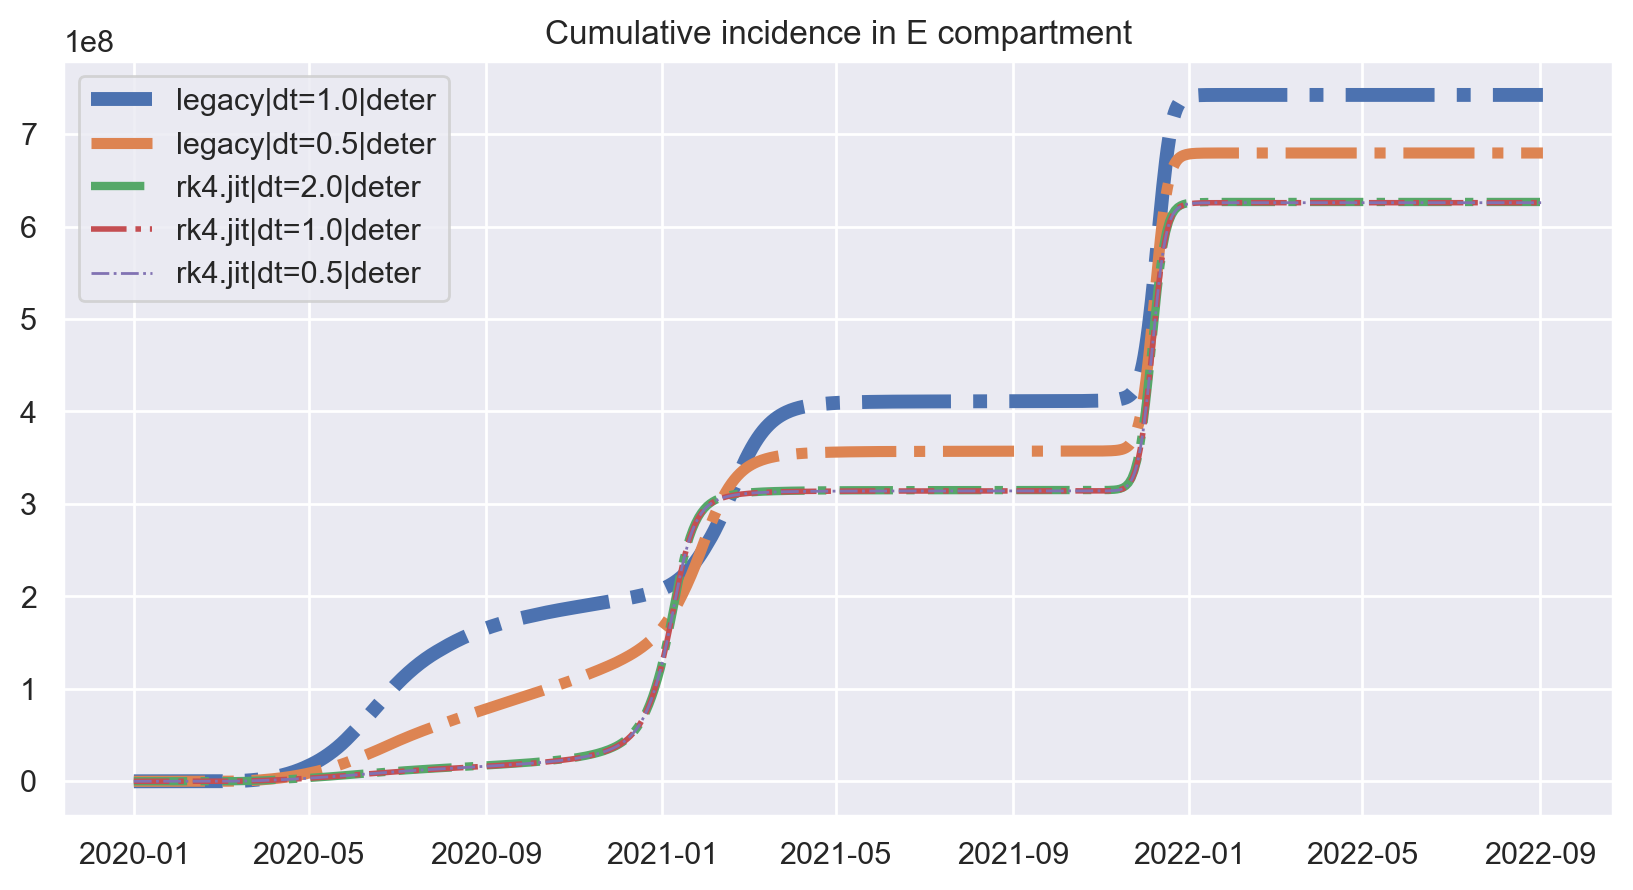

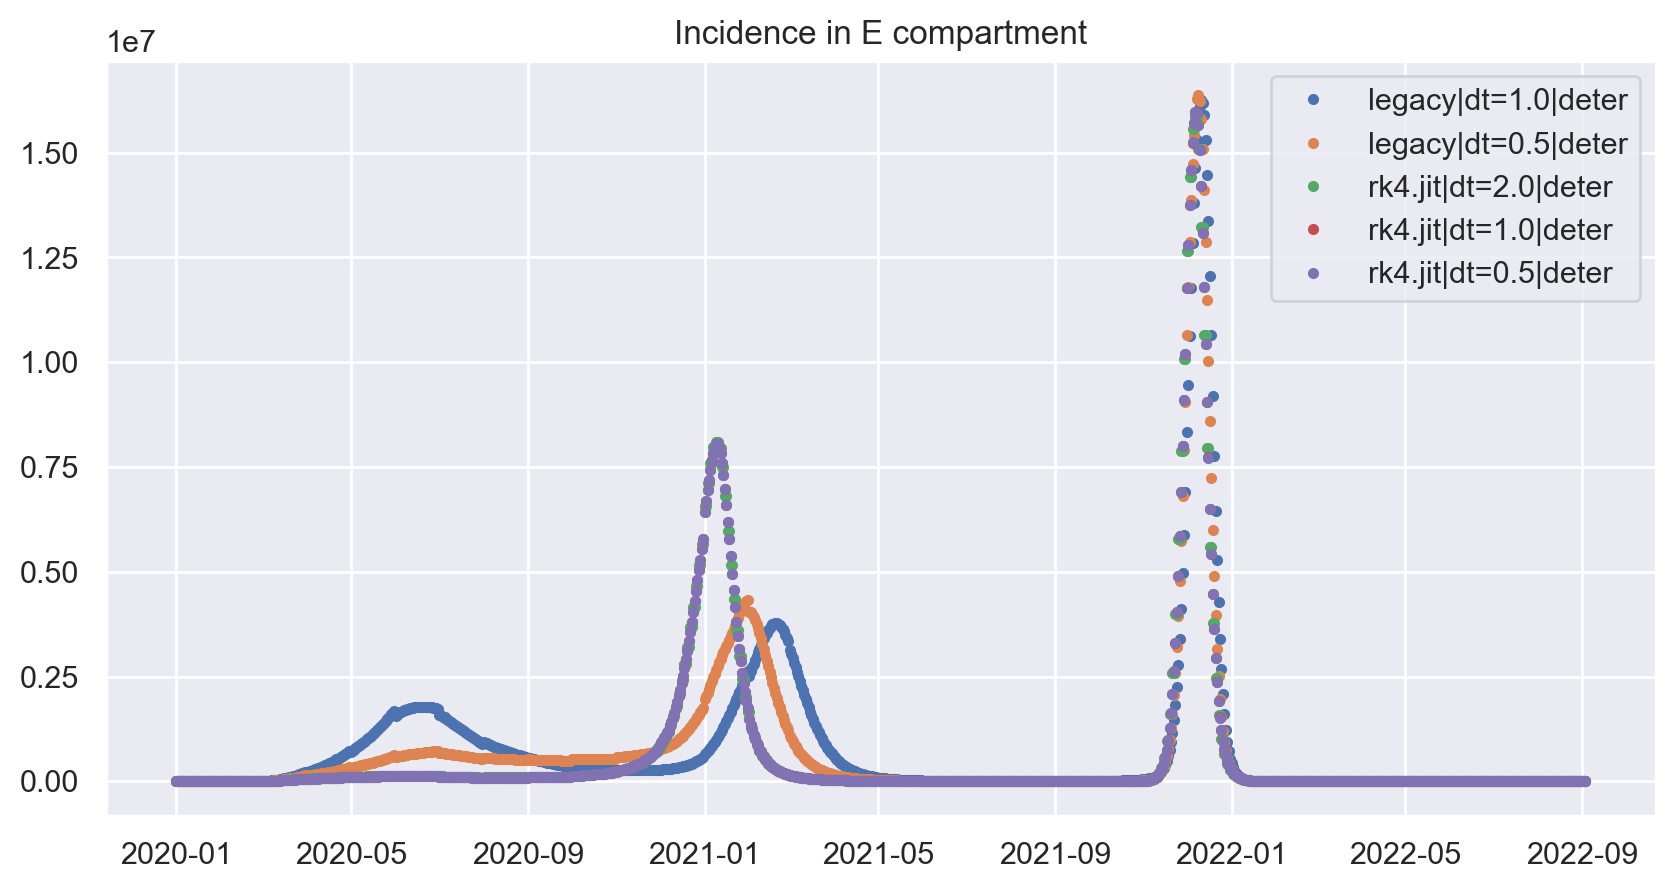

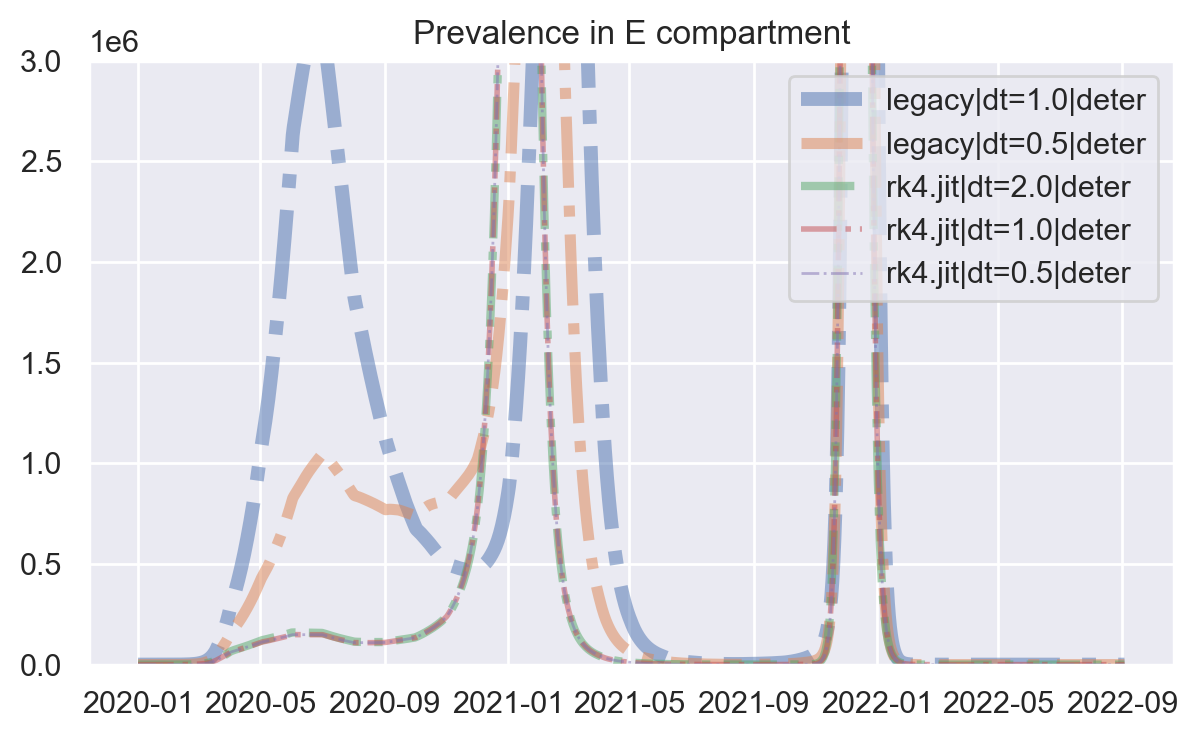

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
lw = 5  # 0
for met, dat in data.items():
    if not "stoch" in met:
        df = dat[(dat["mc_value_type"] == "incidence") & (dat["mc_infection_stage"] == "E")]
        df = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)
        ax.plot(df.cumsum(), label=met, ls="-.", alpha=1, lw=lw)  # , marker='o')
        lw -= 1
ax.legend()
ax.set_title("Cumulative incidence in E compartment")
# ax.set_ylim(0, 3e6)

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
lw = 5  # 0
for met, dat in data.items():
    if not "stoch" in met:
        df = dat[(dat["mc_value_type"] == "incidence") & (dat["mc_infection_stage"] == "E")]
        df = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)
        ax.plot(df, label=met, alpha=1, lw=lw, marker=".", ls="")  # ls="-.",
        lw -= 1
ax.legend()
ax.set_title("Incidence in E compartment")
# ax.set_ylim(0, 3e6)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=200)
lw = 5
for met, dat in data.items():
    if not "stoch" in met:
        df = dat[(dat["mc_value_type"] == "prevalence") & (dat["mc_infection_stage"] == "I1")]
        df = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)
        ax.plot(df, label=met, ls="-.", alpha=0.5, lw=lw)
        lw -= 1
ax.legend()
ax.set_title("Prevalence in E compartment")
ax.set_ylim(0, 3e6)

## Check if stochastic compares to deterministic runs

(0.0, 500000.0)

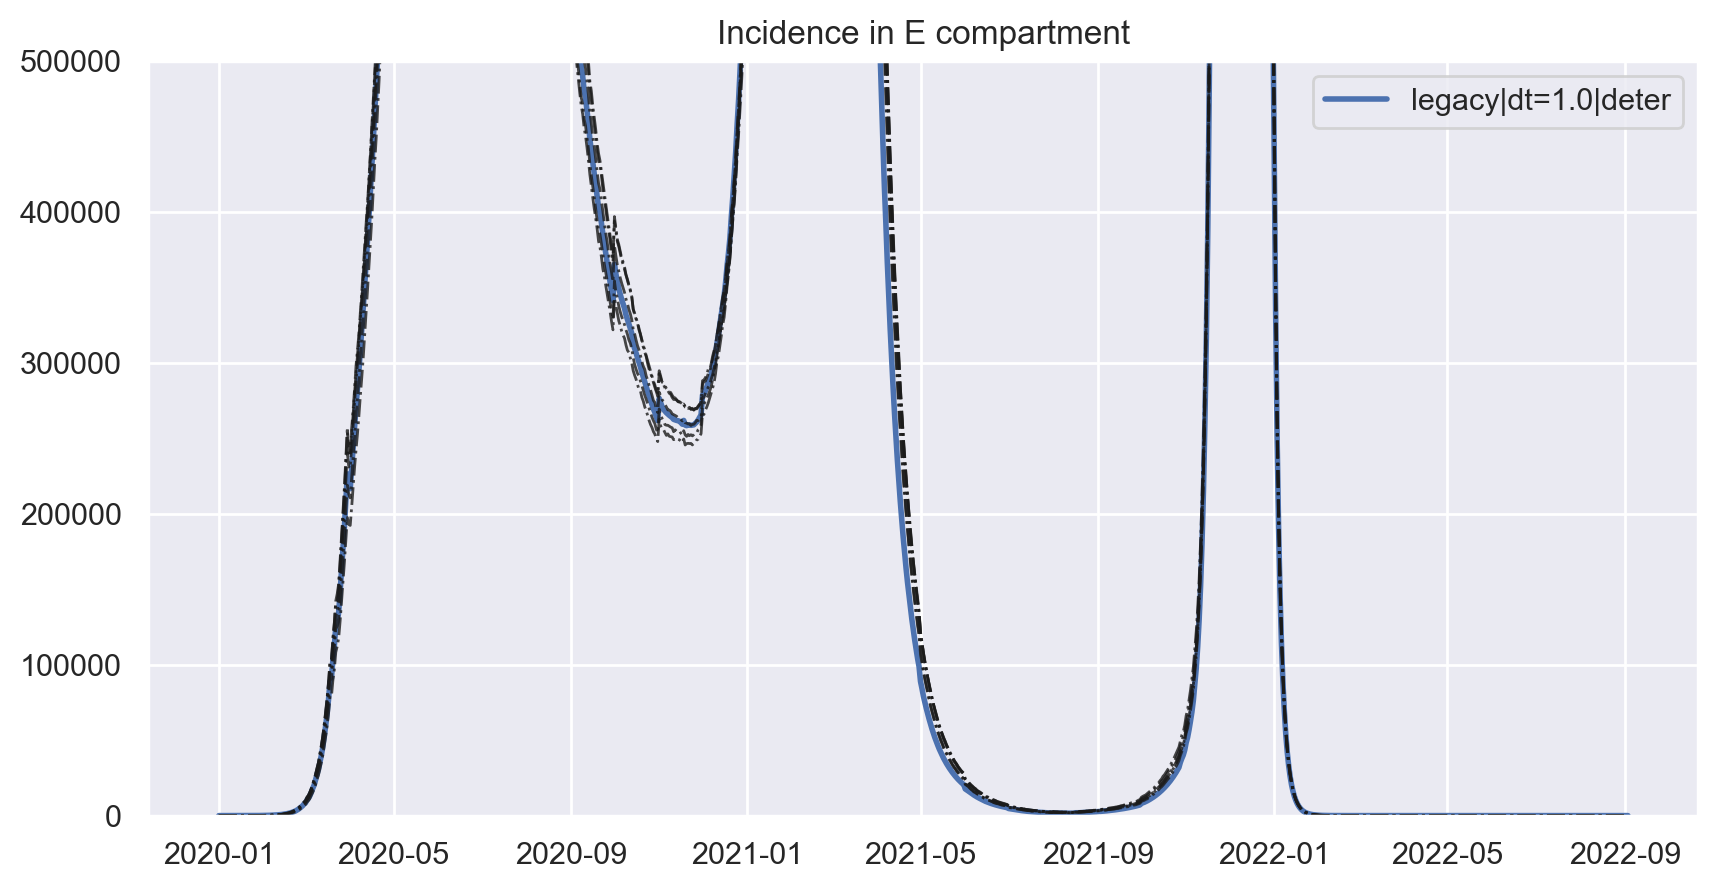

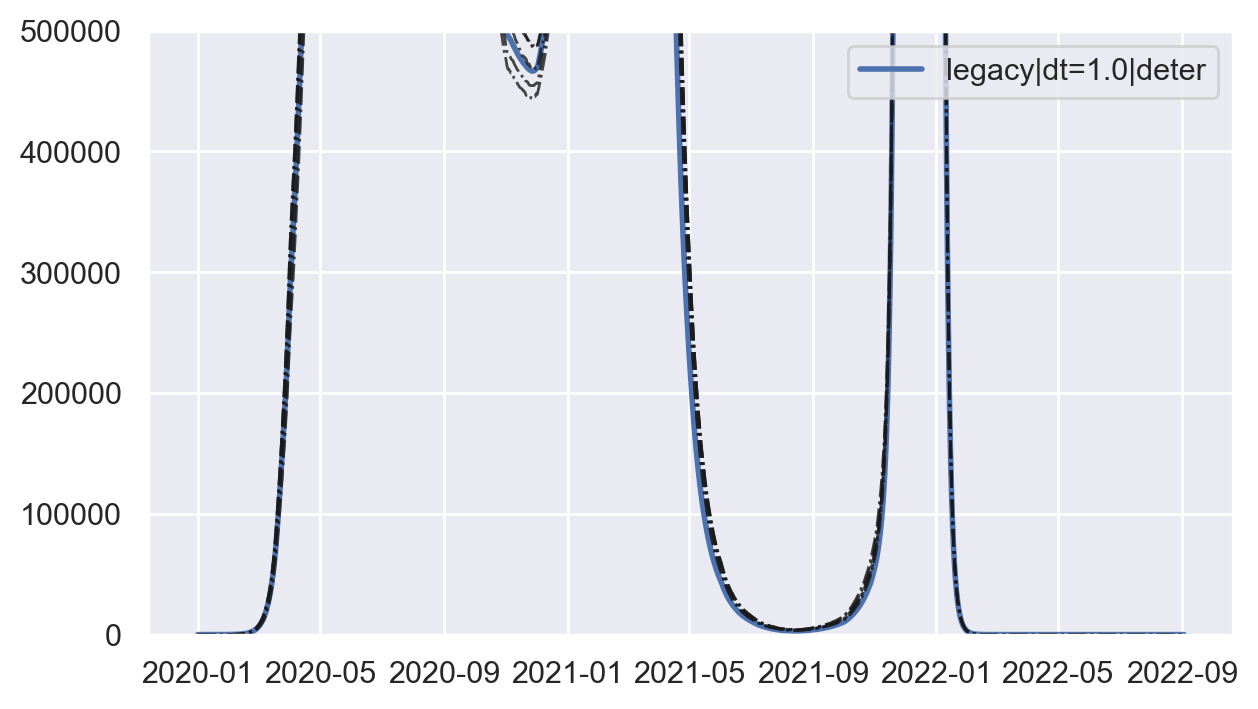

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
lw = 2  # 0
for met, dat in data.items():
    if "legacy" in met and "dt=1" in met:
        df = dat[(dat["mc_value_type"] == "incidence") & (dat["mc_infection_stage"] == "E")]
        df = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)
        if "stoch" in met:
            ax.plot(df, label="", ls="-.", alpha=0.8, lw=lw / 2, c="k")
        else:
            ax.plot(df, label=met, ls="-", alpha=1, lw=lw)


ax.legend()
ax.set_title("Incidence in E compartment")
ax.set_ylim(0, 0.5e6)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=200)
lw = 2
for met, dat in data.items():
    if "legacy" in met and "dt=1" in met:
        df = dat[(dat["mc_value_type"] == "prevalence") & (dat["mc_infection_stage"] == "I1")]
        df = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)
        if "stoch" in met:
            ax.plot(df, label="", ls="-.", alpha=0.8, lw=lw / 2, c="k")
        else:
            ax.plot(df, label=met, ls="-", alpha=1, lw=lw)
ax.legend()
ax.set_ylim(0, 0.5e6)

## Error with rk4.jit with dt=2 vs dt=1

Text(0.5, 1.0, 'error: Incidence in E compartment')

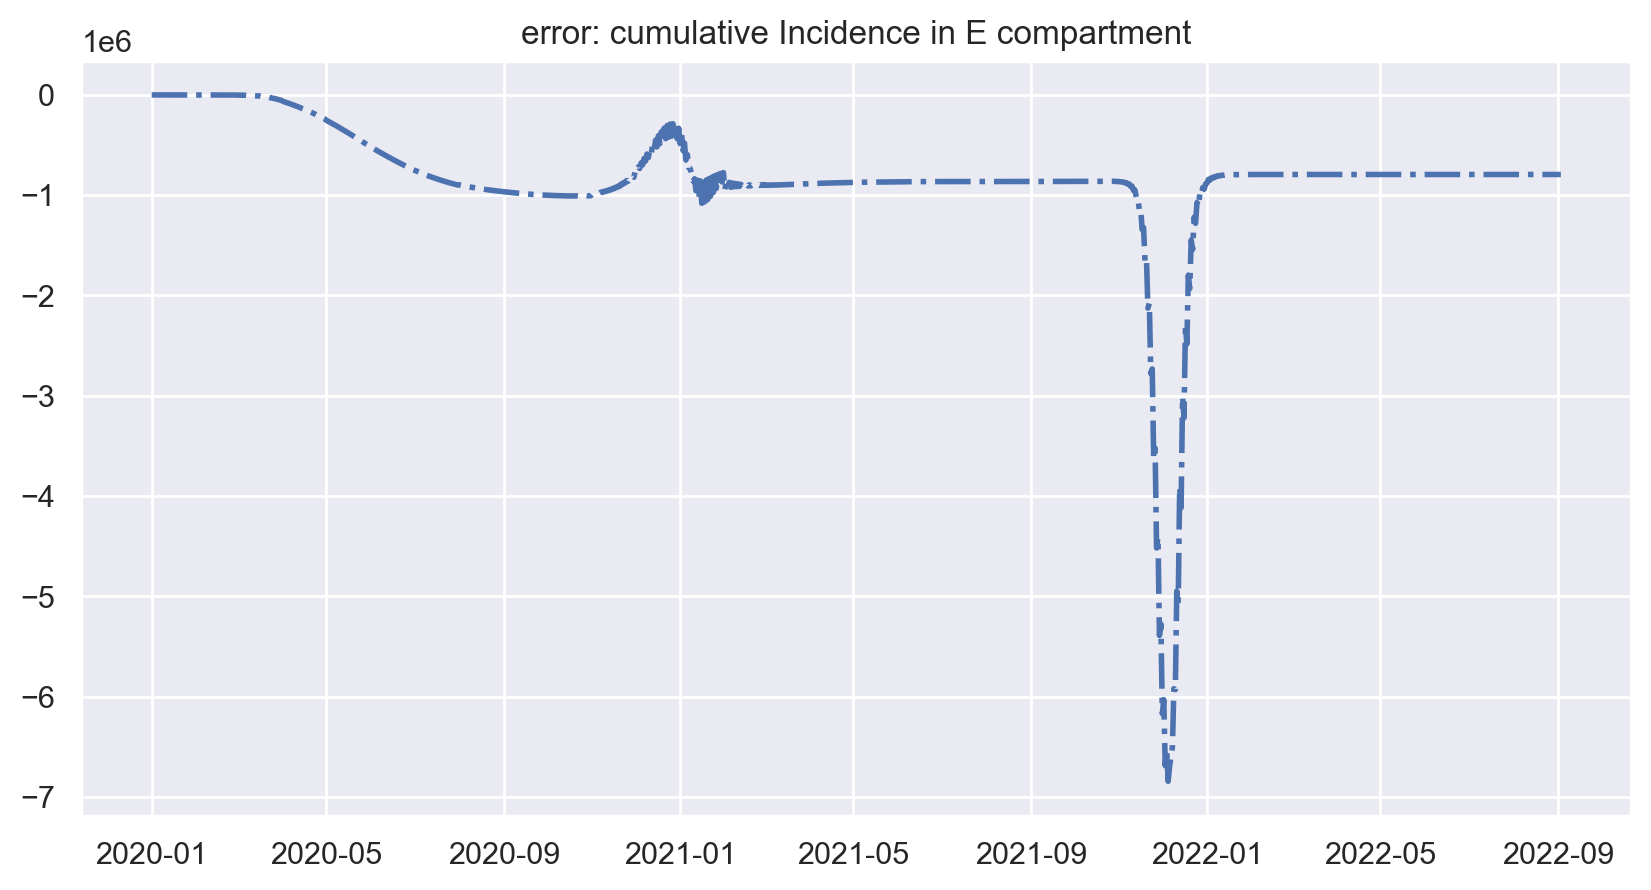

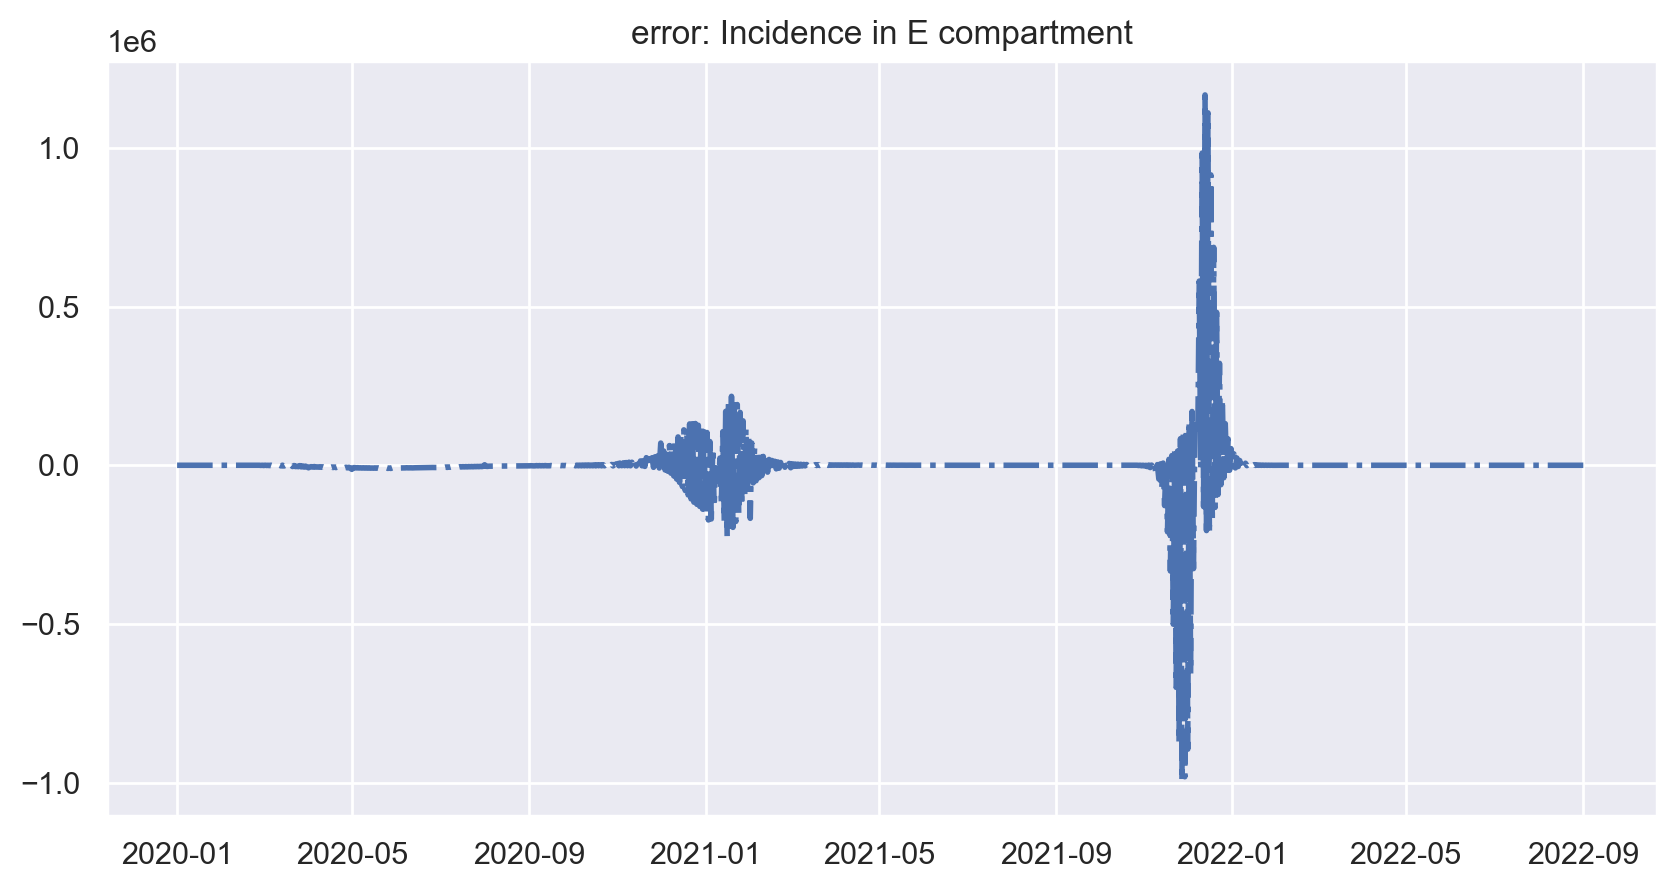

In [18]:
dat = data["rk4.jit|dt=2.0|deter"]
df = dat[(dat["mc_value_type"] == "incidence") & (dat["mc_infection_stage"] == "E")]
df2 = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)

dat = data["rk4.jit|dt=1.0|deter"]
df = dat[(dat["mc_value_type"] == "incidence") & (dat["mc_infection_stage"] == "E")]
df1 = df.reset_index(drop=True).groupby(by="date").sum().sum(axis=1)


fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
ax.plot(df1.cumsum() - df2.cumsum(), label=met, ls="-.", alpha=1, lw=2)  # , marker='o')
ax.set_title("error: cumulative Incidence in E compartment")

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
ax.plot(df1 - df2, label=met, ls="-.", alpha=1, lw=2)  # , marker='o')
ax.set_title("error: Incidence in E compartment")

In [13]:
# relative error:
(df1.sum() - df2.sum()) / df1.sum() * 100

-0.126769952136082

## Conclusions

- stochastic works and is similar to non-stochastic for legacy
- there is no need for lower time steps with rk4, all the same
- legacy is really bad and needs very small timesteps to behave normally
- dt=2 works and provides good accuracy

### choosing between method that conserve cumulative case to interpolate incidence:

In [14]:
import numpy as np
import scipy

ndays = 977
states_daily_incid_org = np.load("test.npy")
states_daily_incid_org.sum()

4742406282.8800335

In [15]:
states_daily_incid = np.load("test.npy")
states_daily_incid = states_daily_incid / 2
states_daily_incid[1::2, :, :] = states_daily_incid[:-1:2, :, :]
states_daily_incid.sum()

4741454272.883266

In [16]:
states_daily_incid = np.load("test.npy")
states_i_f = scipy.interpolate.interp1d(
    np.arange(ndays, step=2), states_daily_incid[::2, :, :] / 2, axis=0, kind="linear"
)
states_daily_incid = states_i_f(np.arange(ndays))
states_daily_incid.sum()

4678812753.881658

In [17]:
states_daily_incid = np.load("test.npy")
states_i_f = scipy.interpolate.interp1d(np.arange(ndays, step=2), states_daily_incid[::2, :, :], axis=0, kind="linear")
states_daily_incid = states_i_f(np.arange(ndays)) / 2
states_daily_incid.sum()

4678812753.881658